In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import meter as m
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as st

In [2]:
#Laster inn energidata fra Statsbygg EOS
power = pd.read_excel('Timeforbruk av energi for perioden 01.01.2021 - 21.11.2021.xlsx')
# Laster inn utetemperaturer
utetemp = pd.read_excel('table.xlsx')

In [3]:
power = power[3:len(power)-4]
col = ['date', 'meter','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22', '23', '24', 'sum']
drops = ['sum']
if len(power.columns) > 27:
    col = ['date', 'meter','type', 'unit', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22', '23', '24', 'sum']
    drops = ['sum', 'type', 'unit']
power.columns = col
power = power.drop(labels =drops, axis=1)
power['date'] =pd.to_datetime(power['date'], format='%d.%m.%Y')
power = power.set_index(['meter', 'date'])
power = power.stack().reset_index()
power.columns = ['meter', 'date', 'hour', 'power']
power.date = power.date + pd.to_timedelta(power.hour+':00:00')
power = power.reset_index()
#power = power.set_index(['date'])
meters = power.pivot(index='index', columns='meter', values='power').columns.tolist()
if 'Snitt' in meters:
    meters.remove('Snitt')
if 'Snitt ukedager' in meters:
    meters.remove('Snitt ukedager')

utecols = ['Navn', 'Stasjon', 'Time', 'Temp']
utetemp.columns = utecols
utetemp = utetemp[utetemp.columns.tolist()[2:]]
utetemp['Time'] = pd.to_datetime(utetemp['Time'], format='%d.%m.%Y %H:%M')

power = power.merge(utetemp, left_on='date', right_on='Time', how='inner')
power['weekday'] = power.date.dt.weekday
power['month'] = power.date.dt.month
power['hour'] = power.date.dt.hour
powerNatt = power[power['hour'] == '4']
power = power.set_index('date')
meters

['El ab.måler (auto)', 'El til elkjel (auto)', 'El til varmepumpe (auto)']

In [4]:
# Endre variabel "meter" til en av målerne skrevet ut i linjen over
meter = 'El til elkjel (auto)'

In [3]:
power = m.init_data()

In [4]:
a = m.Building("test", 199, 199)
a.set_weather_data('Ørsta-volda Lufthamn')

Data retrieved from frost.met.no!
Data retrieved from frost.met.no!


In [5]:
#power.index = pd.to_datetime(power.index).tz_localize('Etc/UCT')
a.setOneMeter(power[power['meter']==meter].power)

AttributeError: 'Index' object has no attribute 'weekday'

Text(0.5, 1.0, 'Energiforbruk 2021 for El til elkjel (auto)')

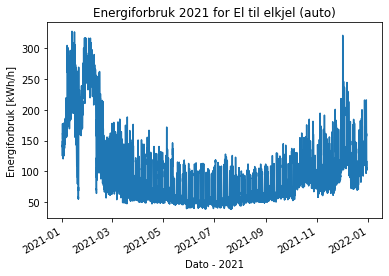

In [5]:
# Graf over energiforbruk i angitt periode
# NB! Hoppene man ser med jevnlige mellomrom i grafen under skyldes hull i tidsserien. Jobber med å finne en løsning
#power = power.set_index(['date'])
power[(power['meter']==meter) & (power.index < '2022-01-01')]['power'].plot()

plt.xlabel('Dato - 2021')
plt.ylabel('Energiforbruk [kWh/h]')

# Tittel
plt.title('Energiforbruk 2021 for ' + meter)
#plt.legend()

In [94]:
power.power

date
2021-01-01 01:00:00        0
2021-01-01 01:00:00    141.8
2021-01-01 02:00:00      0.0
2021-01-01 02:00:00    125.0
2021-01-01 03:00:00      0.0
                       ...  
2021-12-30 20:00:00      0.0
2021-12-30 21:00:00      0.0
2021-12-30 22:00:00      0.0
2021-12-30 23:00:00      0.0
2021-12-31 00:00:00      0.0
Name: power, Length: 17462, dtype: object

<AxesSubplot:xlabel='Temp', ylabel='pDiff'>

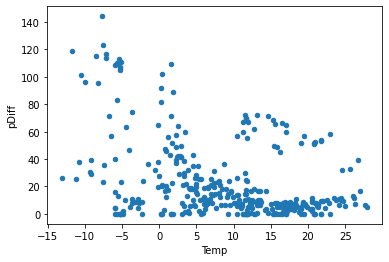

In [108]:
#a.meters[1].meter_data
power2 = power[power.power>0]
power_min = power2.resample('D')['power'].min()
power_max = power2.resample('D')['power'].max()
        
varme2 = power2.merge(power_min.rename('powerMin'), left_index=True, right_index=True, how='outer')
varme2 = varme2.merge(power_max.rename('powerMax'), left_index=True, right_index=True, how='outer')
#varme2['pDiff'] = (varme2.powerMax-varme2.powerMin)
varme2 = varme2.ffill(axis = 0)
varme2['pDiff'] = (varme2.power-varme2.powerMin)
varme2 = varme2.dropna()
varme2 = varme2.between_time('10:00', '12:00')
#varme2 = varme2[(varme2.pDiff>2)&(varme2.pDiff<40)]
varme2 = varme2[varme2.weekday>4]
varme2.plot.scatter(x='Temp', y='pDiff')
#varme2.powerMin.plot()

In [9]:
self = a.meters[0].day_load

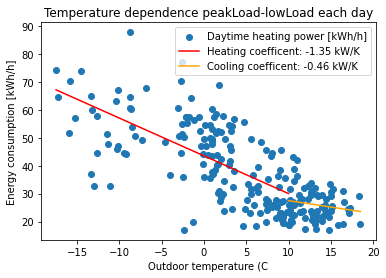

In [10]:
self.view_plot_day()

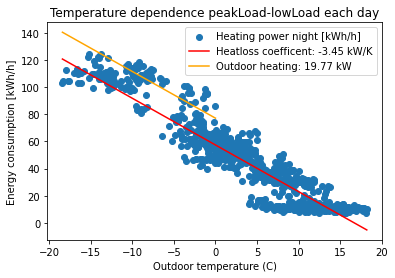

In [11]:
self.view_plot_night()

In [9]:
self.heating_start_temp

13.887418775260674

In [10]:
power_min = self.meter_data.resample('D')['power'].min()
power_max = self.meter_data.resample('D')['power'].max()
varme2 = self.meter_data.merge(power_min.rename('powerMin'), left_index=True, right_index=True, how='outer')
varme2 = varme2.merge(power_max.rename('powerMax'), left_index=True, right_index=True, how='outer')
varme2['pDiff'] = varme2.powerMax-varme2.powerMin
varme2.dropna(inplace=True)
confidence = 0.95
cInterval = np.percentile(varme2.pDiff,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])
varme2 = varme2[varme2.pDiff>cInterval[0]]

#Heatingdependend ventilation
linear_regressor = LinearRegression()
pow = varme2[varme2.temperature<10].pDiff.values.reshape(-1, 1)
temp = varme2[varme2.temperature<10].temperature.values.reshape(-1, 1)
linear_regressor.fit(temp, pow)
self.ventilation_heating = linear_regressor.coef_[0][0]  # kW heating power for heating of outdoor air
self.ventilation_heating_at0 = linear_regressor.intercept_[0] 
self.start_temp_for_ventilation_heating = -self.ventilation_heating_at0/self.ventilation_heating

linear_regressor = LinearRegression()
pow = varme2[varme2.temperature>10].pDiff.values.reshape(-1, 1)
temp = varme2[varme2.temperature>10].temperature.values.reshape(-1, 1)
linear_regressor.fit(temp, pow)
self.ventilation_cooling = linear_regressor.coef_[0][0]  # kW heating power for heating of outdoor air
self.ventilation_cooling_at0 = linear_regressor.intercept_[0]
self.start_temp_for_ventilation_cooling = self.ventilation_cooling_at0/self.ventilation_cooling

-0.9445949622311177
28.02611279765633


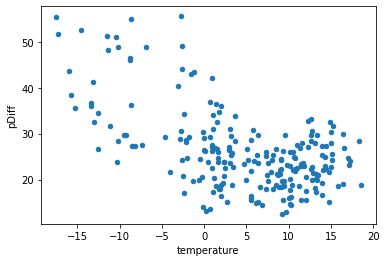

In [34]:
varme2.plot.scatter(x='temperature', y='pDiff')
print(self.ventilation_heating)
print(self.ventilation_heating_at0)

In [31]:
confidence = 0.95
np.percentile(varme2.pDiff,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

array([12.77  , 51.0975])

In [45]:
a = linear_regressor.coef_
b = linear_regressor.intercept_
print(a)
print(b)
print(-b/a)

[-0.83651125 14.07566481  2.75102697]
20.18086815727812
[24.12504088 -1.43374174 -7.33575802]


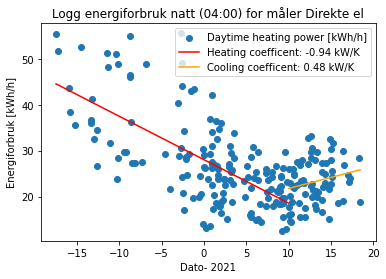

In [25]:
plt.scatter(varme2.temperature, varme2.pDiff)
tMin = min(varme2.temperature)
tMax = 10
Y_pred_min = self.ventilation_heating_at0 + self.ventilation_heating * tMin
Y_pred_max = self.ventilation_heating_at0 + self.ventilation_heating * tMax

tMin2 = 10
tMax2 = max(varme2.temperature)
Y_pred_min2 = self.ventilation_cooling_at0 + self.ventilation_cooling * tMin2
Y_pred_max2 = self.ventilation_cooling_at0 + self.ventilation_cooling * tMax2

Y_pred = [self.ventilation_heating_at0]
plt.plot([tMin, tMax], [Y_pred_min, Y_pred_max], color='red')
plt.plot([tMin2, tMax2], [Y_pred_min2, Y_pred_max2], color='orange')

plt.xlabel('Dato- 2021')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('Logg energiforbruk natt (04:00) for måler ' + meter)
plt.legend(['Daytime heating power [kWh/h]', 'Heating coefficent: ' + str(round(self.ventilation_heating,2)) + ' kW/K', 'Cooling coefficent: ' + str(round(self.ventilation_cooling,2)) + ' kW/K'])

plt.show()

In [69]:
Y = pow.values.reshape(-1, 1) - Y_pred

In [7]:
power.loc['2021-12-20':'2021-12-31']

,index,meter,hour,power,Time,Temp,weekday,month
date,,,,,,,,
2021-12-20 00:00:00,16928,El ab.måler (auto),0,0.0,2021-12-20 00:00:00,3.1,0,12
2021-12-20 00:00:00,16952,El til elkjel (auto),0,77.8,2021-12-20 00:00:00,3.1,0,12
2021-12-20 01:00:00,16953,El ab.måler (auto),1,0,2021-12-20 01:00:00,3.7,0,12
2021-12-20 01:00:00,16977,El til elkjel (auto),1,107,2021-12-20 01:00:00,3.7,0,12
2021-12-20 02:00:00,16954,El ab.måler (auto),2,0.0,2021-12-20 02:00:00,3.2,0,12
...,...,...,...,...,...,...,...,...
2021-12-30 20:00:00,17457,El ab.måler (auto),20,0.0,2021-12-30 20:00:00,0.8,3,12
2021-12-30 21:00:00,17458,El ab.måler (auto),21,0.0,2021-12-30 21:00:00,1.0,3,12
2021-12-30 22:00:00,17459,El ab.måler (auto),22,0.0,2021-12-30 22:00:00,0.8,3,12


Text(0.5, 1.0, 'Døgnplott for El til elkjel (auto)')

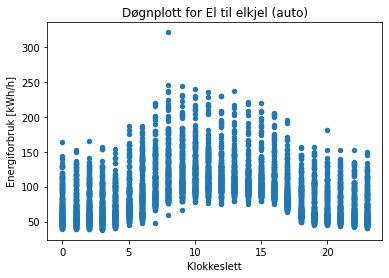

In [14]:
# Døgnplott for valgt måler
#power = power[power]
power[(power['meter']==meter)&(power.weekday<5)].loc['2021-03-01':'2021-12-31'].plot.scatter(x='hour', y='power');
plt.xlabel('Klokkeslett')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('Døgnplott for ' + meter)
#plt.legend()

Text(0.5, 1.0, 'ET-kurve for Direkte el')

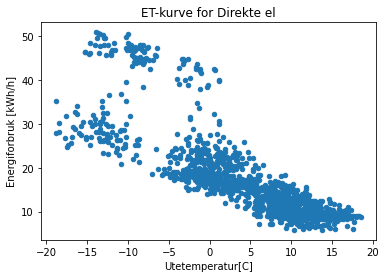

In [12]:
# ET-kurve for valgt måler
power[power['meter']==meter].between_time('01:00', '04:00').plot.scatter(x='Temp', y='power')
plt.xlabel('Utetemperatur[C]')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('ET-kurve for ' + meter)
#plt.legend()

Text(0.5, 1.0, 'ET-kurve for måler Direkte el over 18 grader C')

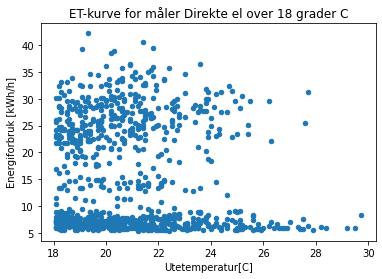

In [13]:
# ET-kurve for valgt måler med filtrering på utetemperatur
# Aktuelt for ELkjel eller fjernvarme for å studere produksjon ved høye / lav temperaturer
temp = 18
zoom = power[power['Temp']>temp]
zoom[zoom['meter']==meter].plot.scatter(x='Temp', y='power')
plt.xlabel('Utetemperatur[C]')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('ET-kurve for måler ' + meter + ' over ' + str(temp) + ' grader C')
#plt.legend()

Text(0.5, 1.0, 'Ukeplott for måler El til elkjel (auto)')

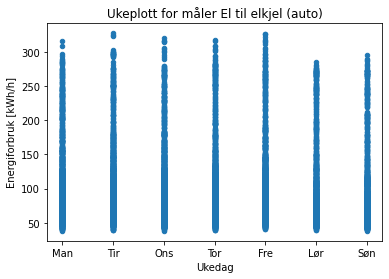

In [109]:
# Ukeplott for angitt måler
# Aktuelt for å sjekke varisjoner i drift (helg og evt. spesielle ukedager)
power[power['meter']==meter].plot.scatter(x='weekday', y='power')
plt.xticks([0,1,2,3,4,5,6],['Man', 'Tir', 'Ons', 'Tor', 'Fre', 'Lør', 'Søn'])
plt.xlabel('Ukedag')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('Ukeplott for måler ' + meter)
#plt.legend()


Text(0.5, 1.0, 'Månedsplott for måler El til elkjel (auto)')

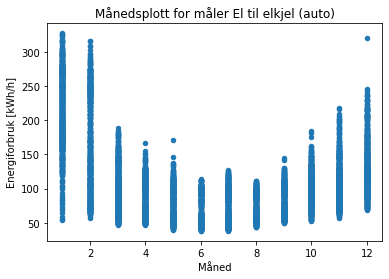

In [110]:
# Ukeplott for angitt måler
# Aktuelt for å sjekke varisjoner i drift (helg og evt. spesielle ukedager)
power[power['meter']==meter].plot.scatter(x='month', y='power')
plt.xlabel('Måned')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('Månedsplott for måler ' + meter)
#plt.legend()


Text(0.5, 1.0, 'ET-kurve natt (04:00) for måler Direkte el')

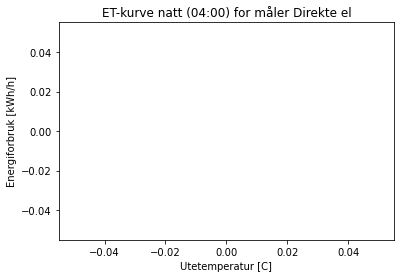

In [16]:
powerNatt[powerNatt['meter'] == meter].plot.scatter(x='Temp', y='power')
plt.xlabel('Utetemperatur [C]')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('ET-kurve natt (04:00) for måler ' + meter)
#plt.legend()


In [17]:
# Logg energiforbruk natt.
# Nyttig for å sjekke styring varmekabel/ elektrisk oppvarming, samt nattlast (pumper og evt. lys - avhengig av drift)
powerNatt.set_index('date', inplace=True)
a = powerNatt[powerNatt['meter'] == meter]['power'].plot()
powerNatt[powerNatt['meter'] == meter]['Temp'].plot(ax=a)
plt.xlabel('Dato- 2021')
plt.ylabel('Energiforbruk [kWh/h]')
 
# Tittel
plt.title('Logg energiforbruk natt (04:00) for måler ' + meter)
plt.legend([meter, 'Utetemperatur'])

TypeError: no numeric data to plot

In [26]:
# Simulering varmepumpe
# Legg inn effekt varmepumpe
effektVP = 40
power['Varmepumpe'] = power['power']
power['Varmepumpe'][power['Varmepumpe'] > effektVP] = effektVP


C:\Users\amy\AppData\Local\Temp/ipykernel_14412/118762329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power['Varmepumpe'][power['Varmepumpe'] > effektVP] = effektVP


In [102]:
# Andel varmepumpeproduksjon
sum(power['Varmepumpe'])/sum(power['power'])

0.8650790901151465

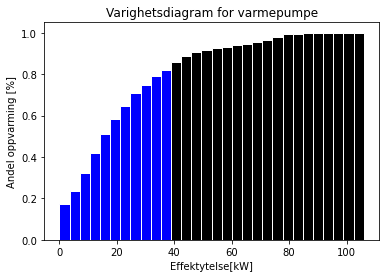

In [105]:
fig, ax = plt.subplots()

N, bins, patches = ax.hist(power['power']-min(power['power']), edgecolor='white', linewidth=1, cumulative=True, bins=30, density=1)
cutVP = round(effektVP/max(power.power)*30)
for i in range(0,cutVP):
    patches[i].set_facecolor('b')
for i in range(cutVP, len(patches)):
    patches[i].set_facecolor('black')
plt.xlabel('Effektytelse[kW]')
plt.ylabel('Andel oppvarming [%]')
 
# Tittel
plt.title('Varighetsdiagram for varmepumpe')
plt.show()

<ipython-input-37-70d697d3b40f>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  varme2.dropna()[varme2.weekday<5].plot.scatter(x='Temp', y='pDiff')


<AxesSubplot:xlabel='Temp', ylabel='pDiff'>

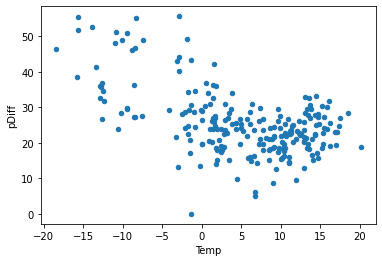

In [37]:
varme = power[power['meter']==meter]
varmeDag = varme.resample('D')['power'].min()
varmeDag2 = varme.resample('D')['power'].max()
#varmeDag = varmeDag.resample('H').ffill()
#varmeDag2 = varmeDag2.resample('H').ffill()
varme2 = varme.merge(varmeDag.rename('new'), left_index=True, right_index=True, how='outer')
varme2 = varme2.merge(varmeDag2.rename('new2'), left_index=True, right_index=True, how='outer')
varme2['pDiff'] = varme2.new2-varme2.new
varme2.dropna()[varme2.weekday<5].plot.scatter(x='Temp', y='pDiff')
#varme2.dropna()